## Setup

In [1]:
# Import libraries
import os
import random
import glob
import time
import pickle
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2025-12-12 09:33:07.797242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765531987.952974      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765531987.997534      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# Configuration
DATA_ROOT = "/kaggle/input/acme-ai/temporal_jersey_nr_recognition_dataset_subset"
SAVE_DIR = "/kaggle/working/jersey_project"
os.makedirs(SAVE_DIR, exist_ok=True)

SEQ_LENGTH = 8
IMG_SIZE = 96
BATCH_SIZE = 8
EPOCHS = 12
LR = 3e-4
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

# set seed for reproducibility
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

## File listing & frame reading

In [3]:
def list_sequence_samples(root_dir):
    """Return list of (seq_path, label) for every sequence folder."""
    samples = []
    for class_name in sorted(os.listdir(root_dir)):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        try:
            label = int(class_name)
        except:
            continue
        for seq_name in sorted(os.listdir(class_path)):
            seq_path = os.path.join(class_path, seq_name)
            if os.path.isdir(seq_path):
                samples.append((seq_path, label))
    return samples

def find_frame_paths(seq_path):
    """Find jpgs either directly under seq_path or under first inner folder."""
    jpgs = [f for f in os.listdir(seq_path) if f.lower().endswith(".jpg")]
    if len(jpgs) > 0:
        # exclude anchor.jpg from regular frames
        return [os.path.join(seq_path, f) for f in sorted(jpgs) if f.lower() != "anchor.jpg"]
    # check nested folder
    subfolders = [d for d in os.listdir(seq_path) if os.path.isdir(os.path.join(seq_path, d))]
    if len(subfolders) > 0:
        inner = os.path.join(seq_path, subfolders[0])
        inner_jpgs = [f for f in os.listdir(inner) if f.lower().endswith(".jpg")]
        return [os.path.join(inner, f) for f in sorted(inner_jpgs)]
    return []

## Preprocessing

In [4]:
# Load PIL image, resize, convert to array normalized for MobileNetV3Small

def load_and_preprocess_image(path, img_size=IMG_SIZE):
    img = Image.open(path).convert("RGB")
    img = img.resize((img_size, img_size), Image.BILINEAR)
    arr = np.array(img).astype(np.float32)
    # Use MobileNetV3 preprocessing: rescale to [-1, 1]
    arr = tf.keras.applications.mobilenet_v3.preprocess_input(arr)
    return arr  # H, W, 3 float32

## Sequence buildup

In [5]:
# Return numpy array of shape (T, H, W, 3) and the label as (tens, ones).
# Uses anchor.jpg if no frames exist or optionally appended for training.
    
def build_sequence_array(seq_path, seq_length=SEQ_LENGTH, img_size=IMG_SIZE, use_anchor_in_training=True, training_mode=True):
    # find frames
    frame_paths = find_frame_paths(seq_path)
    imgs = []
    for p in frame_paths:
        try:
            imgs.append(load_and_preprocess_image(p, img_size=img_size))
        except Exception:
            # skip corrupted frames
            continue

    # fallback to anchor if no frames
    if len(imgs) == 0:
        anchor_p = os.path.join(seq_path, "anchor.jpg")
        if os.path.exists(anchor_p):
            imgs.append(load_and_preprocess_image(anchor_p, img_size=img_size))
        else:
            # dummy black image
            imgs.append(np.zeros((img_size, img_size, 3), dtype=np.float32))

    # optionally append anchor during training
    if training_mode and use_anchor_in_training:
        anchor_p = os.path.join(seq_path, "anchor.jpg")
        if os.path.exists(anchor_p):
            try:
                imgs.append(load_and_preprocess_image(anchor_p, img_size=img_size))
            except Exception:
                pass

    # sample or pad to seq_length
    if len(imgs) >= seq_length:
        idxs = np.linspace(0, len(imgs)-1, seq_length).astype(int)
        seq = [imgs[i] for i in idxs]
    else:
        # pad by repeating last
        seq = imgs.copy()
        while len(seq) < seq_length:
            seq.append(seq[-1])
    seq = np.stack(seq, axis=0)  # (T, H, W, 3)
    return seq

## Data Split

In [6]:
all_samples = list_sequence_samples(DATA_ROOT)
random.Random(SEED).shuffle(all_samples)

n = len(all_samples)
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

train_samples = all_samples[:n_train]
val_samples = all_samples[n_train:n_train+n_val]
test_samples = all_samples[n_train+n_val:]

print(f"Total sequences: {n}, train: {len(train_samples)}, val: {len(val_samples)}, test: {len(test_samples)}")

Total sequences: 4547, train: 3637, val: 454, test: 456


## Data load

In [7]:
# Generator function

def generator_from_samples(samples, training_mode=True):
    for (seq_path, label) in samples:
        seq = build_sequence_array(seq_path, seq_length=SEQ_LENGTH, img_size=IMG_SIZE, use_anchor_in_training=True, training_mode=training_mode)
        tens = label // 10
        ones = label % 10
        # model will expect shape (T, H, W, 3) per sample; we'll feed batches of that
        yield seq, (tens, ones)

output_signature = (
    tf.TensorSpec(shape=(SEQ_LENGTH, IMG_SIZE, IMG_SIZE, 3), dtype=tf.float32),
    (tf.TensorSpec(shape=(), dtype=tf.int32), tf.TensorSpec(shape=(), dtype=tf.int32))
)

# Dataset generator
train_ds = tf.data.Dataset.from_generator(lambda: generator_from_samples(train_samples, training_mode=True),
                                          output_signature=output_signature)
val_ds = tf.data.Dataset.from_generator(lambda: generator_from_samples(val_samples, training_mode=False),
                                        output_signature=output_signature)
test_ds = tf.data.Dataset.from_generator(lambda: generator_from_samples(test_samples, training_mode=False),
                                         output_signature=output_signature)

# Batching and performance
train_ds = train_ds.shuffle(512, seed=SEED).batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

I0000 00:00:1765532007.622507      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## Build Model

In [8]:
def build_model(seq_length=SEQ_LENGTH, img_size=IMG_SIZE, hidden_dim=256):
    # input: (T, H, W, 3)
    inp = tf.keras.layers.Input(shape=(seq_length, img_size, img_size, 3), name="frames")
    # process each frame with MobileNetV3Small backbone (weights='imagenet')
    # use TimeDistributed to apply to each frame
    base = tf.keras.applications.MobileNetV3Small(include_top=False, input_shape=(img_size, img_size, 3), pooling='avg', weights='imagenet')
    base.trainable = True  # you can set to False to freeze
    td = tf.keras.layers.TimeDistributed(base)(inp)  # (B, T, feat)
    # td has shape (B, T, feat_dim)
    # apply a small Temporal CNN (1D conv over time)
    x = tf.keras.layers.Conv1D(filters=hidden_dim, kernel_size=3, padding='same', activation='relu')(td)
    x = tf.keras.layers.Conv1D(filters=hidden_dim//2, kernel_size=3, padding='same', activation='relu')(x)
    # global pooling along time to get sequence representation
    x_pool = tf.keras.layers.GlobalAveragePooling1D()(x)  # (B, hidden_dim//2)
    # two output heads
    tens_logits = tf.keras.layers.Dense(10, name='tens')(x_pool)
    ones_logits = tf.keras.layers.Dense(10, name='ones')(x_pool)
    model = tf.keras.Model(inputs=inp, outputs=[tens_logits, ones_logits])
    return model

model = build_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:452: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ frames (InputLayer) │ (None, 8, 96, 96, │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 8, 576)    │    939,120 │ frames[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 8, 256)    │    442,624 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 8, 128)    │     98,432 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tens (Dense)        │ (None, 10)        │      1,290 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ones (Dense)        │ (None, 10)        │      1,290 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,482,756 (5.66 MB)

 Trainable params: 1,470,644 (5.61 MB)

 Non-trainable params: 12,112 (47.31 KB)

## Compile model

In [9]:
losses = {
    "tens": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    "ones": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
}
metrics = {
    "tens": [tf.keras.metrics.SparseCategoricalAccuracy(name="acc")],
    "ones": [tf.keras.metrics.SparseCategoricalAccuracy(name="acc")]
}
optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
model.compile(optimizer=optimizer, loss=losses, metrics=metrics)

## Callback setup

In [10]:
checkpoint_path = os.path.join(SAVE_DIR, "best_tf_model.keras")
ckpt_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True, save_weights_only=False)
reduce_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)

# Callback class

class ExactAccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self, train_ds, val_ds):
        super().__init__()
        self.train_ds = train_ds
        self.val_ds = val_ds
        self.train_exact = []
        self.val_exact = []
        self.train_losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs=None):
        # compute exact acc on train subset (fast: iterate a few batches or full small dataset)
        def compute_exact(ds):
            total = 0
            correct = 0
            loss_sum = 0.0
            for batch in ds:
                frames, (tens_true, ones_true) = batch
                preds = self.model.predict(frames, verbose=0)
                tens_pred = np.argmax(preds[0], axis=1)
                ones_pred = np.argmax(preds[1], axis=1)
                correct += np.sum((tens_pred == tens_true.numpy()) & (ones_pred == ones_true.numpy()))
                total += tens_true.shape[0]
            return correct / total if total>0 else 0.0

        # full val exact acc
        val_exact = compute_exact(self.val_ds.take(10))
        train_exact = compute_exact(self.train_ds.take(10))  # sample ~10% batches for speed

        self.val_exact.append(val_exact)
        self.train_exact.append(train_exact)

        # record losses if available
        if logs is not None:
            self.train_losses.append(logs.get("loss"))
            self.val_losses.append(logs.get("val_loss"))

        print(f" -> epoch {epoch+1}: val_exact={val_exact:.4f} train_exact(sample)={train_exact:.4f}")

# Instantiate callback

exact_cb = ExactAccuracyCallback(train_ds, val_ds)

## Train model

In [11]:
train_steps = len(train_samples) // BATCH_SIZE
val_steps = max(1, len(val_samples) // BATCH_SIZE)

history = model.fit(train_ds,
                    epochs=EPOCHS,
                    steps_per_epoch=train_steps,
                    validation_data=val_ds,
                    validation_steps=val_steps,
                    callbacks=[ckpt_cb, reduce_cb])

# Save training metrics
metrics_save = {
    "history": history.history,
    "train_exact": exact_cb.train_exact,
    "val_exact": exact_cb.val_exact
}
with open(os.path.join(SAVE_DIR, "training_metrics.pkl"), "wb") as f:
    pickle.dump(metrics_save, f)

print("Training finished. Best model saved to:", checkpoint_path)

# Compute exact accuracy AFTER training once
print("Computing final exact accuracy on validation set...")
def compute_full_exact(ds):
    total = 0
    correct = 0
    for frames, (t, o) in ds:
        preds = model.predict(frames, verbose=0)
        t_pred = np.argmax(preds[0], 1)
        o_pred = np.argmax(preds[1], 1)
        correct += np.sum((t_pred == t.numpy()) & (o_pred == o.numpy()))
        total += len(t)
    return correct / total

final_val_exact = compute_full_exact(val_ds)
print("Final Val Exact Accuracy:", final_val_exact)


Epoch 1/12


I0000 00:00:1765532128.997913     105 service.cc:148] XLA service 0x7904100db4e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765532128.998647     105 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765532140.993095     105 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1765532194.400160     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


454/454 ━━━━━━━━━━━━━━━━━━━━ 478s 674ms/step - loss: 1.5429 - ones_acc: 0.4544 - ones_loss: 1.2393 - tens_acc: 0.9404 - tens_loss: 0.3036 - val_loss: 0.7454 - val_ones_acc: 0.7344 - val_ones_loss: 0.6464 - val_tens_acc: 0.9754 - val_tens_loss: 0.0991 - learning_rate: 3.0000e-04
Epoch 2/12
454/454 ━━━━━━━━━━━━━━━━━━━━ 133s 163ms/step - loss: 0.7267 - ones_acc: 0.7491 - ones_loss: 0.6094 - tens_acc: 0.9630 - tens_loss: 0.1191 - val_loss: 0.5059 - val_ones_acc: 0.8214 - val_ones_loss: 0.4716 - val_tens_acc: 0.9933 - val_tens_loss: 0.0344 - learning_rate: 3.0000e-04
Epoch 3/12
454/454 ━━━━━━━━━━━━━━━━━━━━ 73s 160ms/step - loss: 0.5472 - ones_acc: 0.8136 - ones_loss: 0.4534 - tens_acc: 0.9789 - tens_loss: 0.0951 - val_loss: 0.4860 - val_ones_acc: 0.8348 - val_ones_loss: 0.4518 - val_tens_acc: 0.9955 - val_tens_loss: 0.0343 - learning_rate: 3.0000e-04
Epoch 4/12
454/454 ━━━━━━━━━━━━━━━━━━━━ 71s 156ms/step - loss: 0.4606 - ones_acc: 0.8398 - ones_loss: 0.3879 - tens_acc: 0.9836 - tens_loss: 0

## Train/Val Loss/Accuracy curve

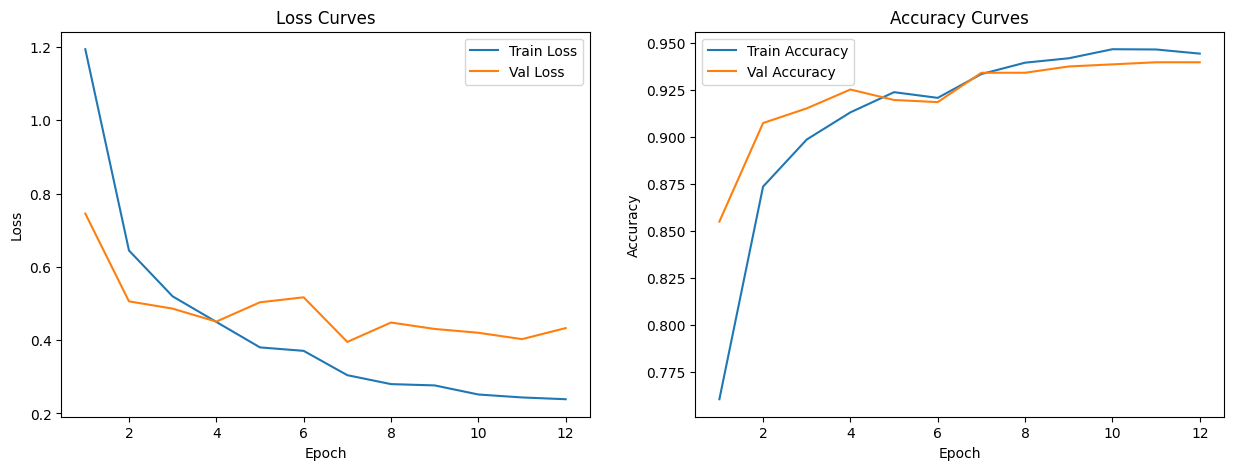

In [13]:
import matplotlib.pyplot as plt

# EXTRACT FROM TF HISTORY
train_loss = history.history["loss"]
val_loss   = history.history["val_loss"]

train_exact = [
    (t + o)/2    # combine tens & ones as proxy
    for t, o in zip(history.history["tens_acc"], history.history["ones_acc"])
]

val_exact = [
    (t + o)/2
    for t, o in zip(history.history["val_tens_acc"], history.history["val_ones_acc"])
]

epochs = range(1, len(train_loss) + 1)

# ---------- PLOT ----------
plt.figure(figsize=(15,5))

# Loss curves
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy curves
plt.subplot(1,2,2)
plt.plot(epochs, train_exact, label="Train Accuracy")
plt.plot(epochs, val_exact, label="Val Accuracy")
plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


## Test best model

In [14]:
best_model = tf.keras.models.load_model(checkpoint_path, compile=False)
best_model.summary()

# evaluate tens/ones accuracy via Keras evaluate (gives per-head metrics)
# create a dataset that yields inputs and a dict of outputs to feed model.evaluate
def prepare_eval_dataset(dataset):
    def map_fn(frames, label_pair):
        tens, ones = label_pair
        # model expects list of two outputs; supply dict
        return frames, {"tens": tens, "ones": ones}
    return dataset.map(map_fn).prefetch(AUTOTUNE)

eval_ds = prepare_eval_dataset(test_ds)
# Note: model must be compiled to use evaluate with losses; we only want predictions -> we'll compute metrics manually below.

# manual evaluation for exact accuracy and per-digit accuracies
total = 0
correct_tens = 0
correct_ones = 0
correct_exact = 0

for batch in test_ds:
    frames, (tens_true, ones_true) = batch
    preds = best_model.predict(frames, verbose=0)
    tens_pred = np.argmax(preds[0], axis=1)
    ones_pred = np.argmax(preds[1], axis=1)

    correct_tens += np.sum(tens_pred == tens_true.numpy())
    correct_ones += np.sum(ones_pred == ones_true.numpy())
    correct_exact += np.sum((tens_pred == tens_true.numpy()) & (ones_pred == ones_true.numpy()))
    total += tens_true.shape[0]

print("TEST RESULTS")
print("Tens acc:", correct_tens / total)
print("Ones acc:", correct_ones / total)
print("Exact acc:", correct_exact / total)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ frames (InputLayer) │ (None, 8, 96, 96, │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 8, 576)    │    939,120 │ frames[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 8, 256)    │    442,624 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 8, 128)    │     98,432 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv1d_1[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tens (Dense)        │ (None, 10)        │      1,290 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ones (Dense)        │ (None, 10)        │      1,290 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,482,756 (5.66 MB)

 Trainable params: 1,470,644 (5.61 MB)

 Non-trainable params: 12,112 (47.31 KB)

TEST RESULTS
Tens acc: 0.9846491228070176
Ones acc: 0.8486842105263158
Exact acc: 0.8486842105263158


## Inference helper

In [16]:
def infer_sequence_tf(model, seq_path, seq_length=SEQ_LENGTH, img_size=IMG_SIZE):
    seq = build_sequence_array(seq_path, seq_length=seq_length, img_size=img_size, training_mode=False)
    # add batch dim
    x = np.expand_dims(seq, axis=0)  # (1, T, H, W, 3)
    preds = model.predict(x, verbose=0)
    tens = int(np.argmax(preds[0], axis=1)[0])
    ones = int(np.argmax(preds[1], axis=1)[0])
    return tens*10 + ones

# quick demo on one folder (adjust path)
demo_path = '/kaggle/input/acme-ai/temporal_jersey_nr_recognition_dataset_subset/66/102_19238/1'  # one example seq folder
print("Demo seq path:", demo_path)
print("Pred:", infer_sequence_tf(best_model, demo_path))

# Save final model (SavedModel format) for submission
# saved_path = os.path.join(SAVE_DIR, "tf_saved_model")
# best_model.save(saved_path, include_optimizer=False)
# print("SavedModel exported to:", saved_path)


Demo seq path: /kaggle/input/acme-ai/temporal_jersey_nr_recognition_dataset_subset/66/102_19238/1
Pred: 66
